# SETUP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set the Kaggle API key path
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"

# Install Kaggle CLI
!pip install --quiet kaggle

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/drive/MyDrive/kaggle_datasets

# Unzip the dataset to Google Drive
!unzip -q "/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia.zip" -d "/content/drive/MyDrive/kaggle_datasets/chest_xray"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


# IMPORTS

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TRANSFORMS

In [5]:
transform_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# DATASET & LOADERS

In [6]:
data_dir = '/content/drive/MyDrive/kaggle_datasets/chest_xray/chest_xray'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# DATA EXPLORATION

In [7]:
def show_class_distribution(dataset, title):
    labels = [label for _, label in dataset.samples]
    class_names = dataset.classes
    class_counts = np.bincount(labels)

    plt.figure(figsize=(6,4))
    sns.barplot(x=class_names, y=class_counts)
    plt.title(f"{title} - Class Distribution")
    plt.ylabel('Number of Images')
    plt.show()


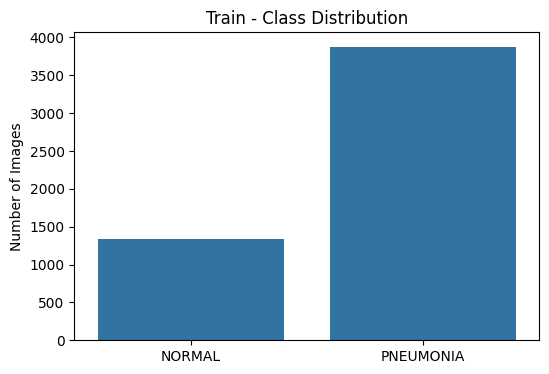

In [8]:
show_class_distribution(train_dataset, "Train")

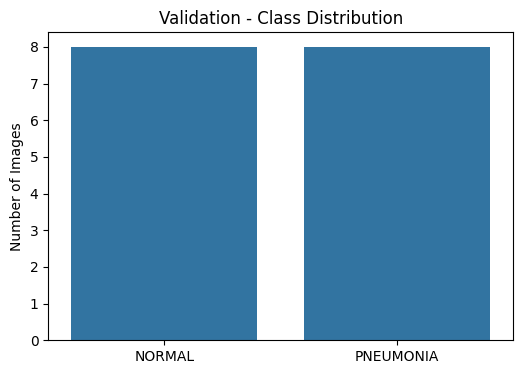

In [9]:
show_class_distribution(val_dataset, "Validation")

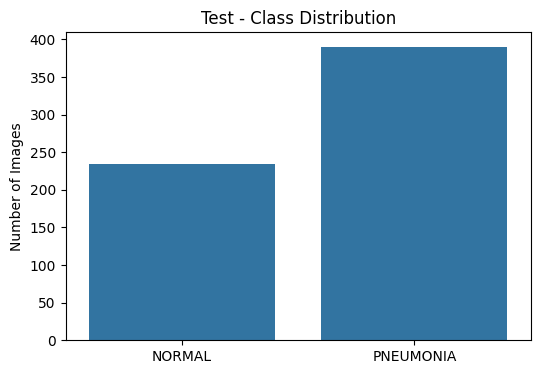

In [10]:
show_class_distribution(test_dataset, "Test")

# Show sample images

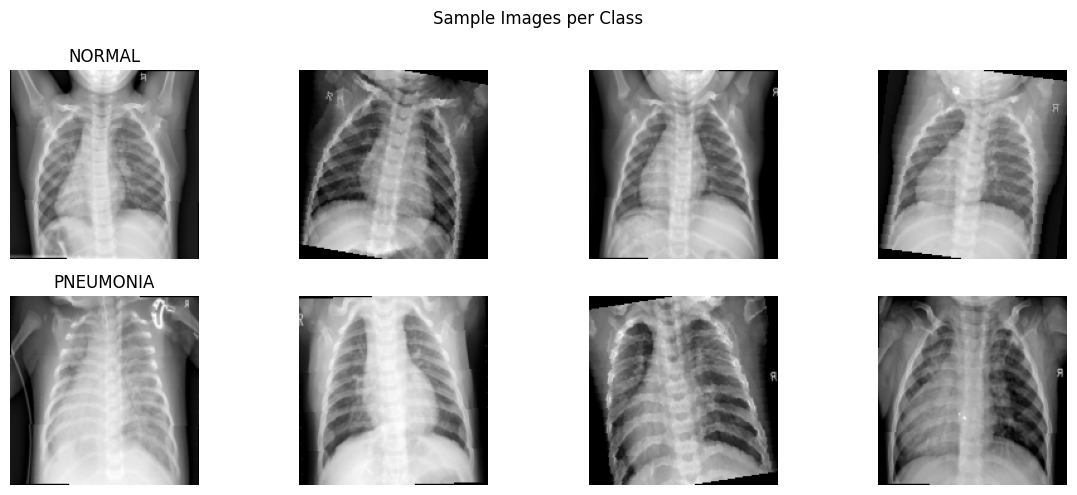

In [11]:
def show_samples(dataset, class_names, samples_per_class=4):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(12, 5))
    for cls_idx, cls_name in enumerate(class_names):
        idxs = [i for i, (_, label) in enumerate(dataset.samples) if label == cls_idx][:samples_per_class]
        for j, idx in enumerate(idxs):
            img, _ = dataset[idx]
            axes[cls_idx, j].imshow(img.squeeze(), cmap='gray')
            axes[cls_idx, j].axis('off')
            if j == 0:
                axes[cls_idx, j].set_title(cls_name)
    plt.suptitle("Sample Images per Class")
    plt.tight_layout()
    plt.show()

show_samples(train_dataset, train_dataset.classes)

# MODEL

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(32 * 18 * 18, 512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = CNN().to(device)

# TRAINING SETUP

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3, min_lr=1e-5)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# TRAINING

In [14]:
def train_model(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def validate_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


In [15]:
num_epochs = 12
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_model(model, val_loader, criterion)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch [1/12] Train Loss: 0.3770, Acc: 0.8357 | Val Loss: 1.1877, Acc: 0.5625
Epoch [2/12] Train Loss: 0.1993, Acc: 0.9271 | Val Loss: 0.5632, Acc: 0.6875
Epoch [3/12] Train Loss: 0.1531, Acc: 0.9444 | Val Loss: 0.5783, Acc: 0.6250
Epoch [4/12] Train Loss: 0.1383, Acc: 0.9479 | Val Loss: 0.5176, Acc: 0.7500
Epoch [5/12] Train Loss: 0.1330, Acc: 0.9503 | Val Loss: 0.4279, Acc: 0.6875
Epoch [6/12] Train Loss: 0.1186, Acc: 0.9559 | Val Loss: 1.0955, Acc: 0.6250
Epoch [7/12] Train Loss: 0.1120, Acc: 0.9569 | Val Loss: 0.6230, Acc: 0.5625
Epoch [8/12] Train Loss: 0.1077, Acc: 0.9632 | Val Loss: 0.7798, Acc: 0.6250
Epoch [9/12] Train Loss: 0.1074, Acc: 0.9622 | Val Loss: 0.4774, Acc: 0.6875
Epoch [10/12] Train Loss: 0.0912, Acc: 0.9684 | Val Loss: 0.5333, Acc: 0.6250
Epoch [11/12] Train Loss: 0.0923, Acc: 0.9672 | Val Loss: 0.5824, Acc: 0.6250
Epoch [12/12] Train Loss: 0.0798, Acc: 0.9732 | Val Loss: 0.5466, Acc: 0.6875


# CURVES

In [16]:
def plot_metrics(train_vals, val_vals, ylabel, title):
    plt.figure(figsize=(6, 4))
    plt.plot(train_vals, label='Train')
    plt.plot(val_vals, label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

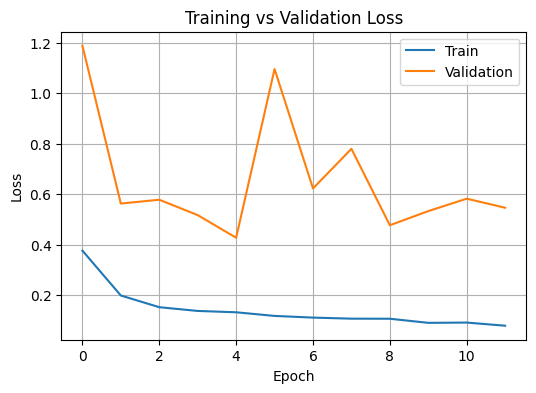

In [17]:
plot_metrics(train_losses, val_losses, "Loss", "Training vs Validation Loss")

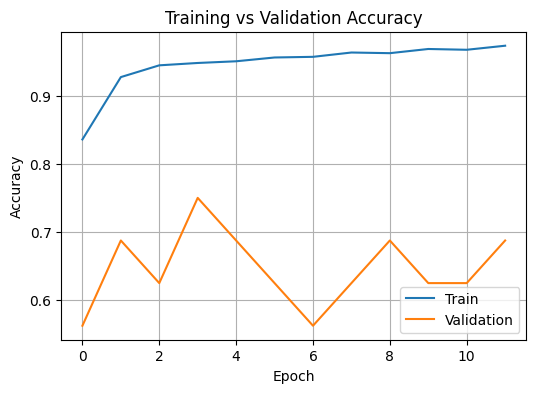

In [18]:
plot_metrics(train_accuracies, val_accuracies, "Accuracy", "Training vs Validation Accuracy")

# EVALUATION

In [19]:
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds).squeeze()

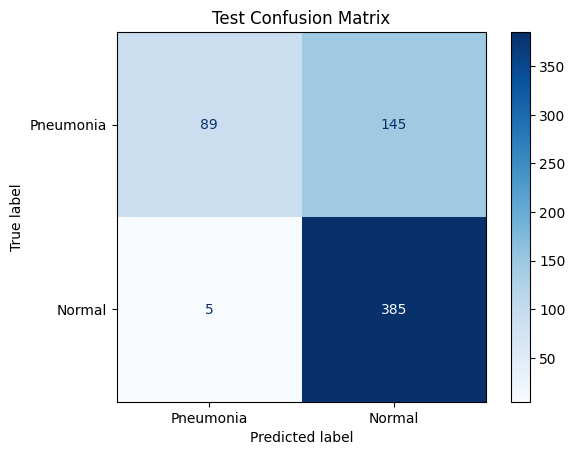

In [20]:
y_true, y_pred = evaluate(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pneumonia', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

# PREDICT SINGLE

In [22]:
def predict_image(image_path):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    output = model(image_tensor)
    prediction = 'Pneumonia' if output.item() > 0.5 else 'Normal'
    print(f"Prediction: {prediction}")

predict_image('/content/drive/MyDrive/kaggle_datasets/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg')

Prediction: Pneumonia


# Save Model

In [23]:
model_path = '/content/drive/MyDrive/pneumonia_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/pneumonia_model.pth
